# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# importing necessary libraries and configurations 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import warnings

plt.style.use("fivethirtyeight")
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
# loading the data 
df = pd.read_csv("crime_reports.csv")

In [3]:
# examining the dataframe 
display(df.shape)
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

(2292998, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2292998 entries, 0 to 2292997
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20870
Address                             12
Zip Code                         14077
Council District                 47068
APD Sector                        8936
APD District                      9410
PRA                              10667
Census Tract                   1537210
Clearance Status                605162
Clearance Date                  335956
UCR Category                   1511610
Category Description           1511610
X-coordinate                     10088
Y-coordinate                     10088
Latitude                         38716
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20125003262,PROTECTIVE ORDER,3829,N,01/23/2012 05:17:00 AM,01/23/2012,517.0,01/23/2012 05:17:00 AM,01/23/2012,517.0,RESIDENCE / HOME,UNKNOWN,NaN,NaN,DA,1,491,NaN,N,01/23/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20072832112,ASSAULT WITH INJURY,900,N,10/10/2007 09:00:00 PM,10/10/2007,2100.0,10/10/2007 10:00:00 PM,10/10/2007,2200.0,BAR / NIGHT CLUB,HOT BODIES CLUB HWY 71 & BURLESON RD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20081232700,FAMILY DISTURBANCE,3400,N,05/02/2008 11:11:00 PM,05/02/2008,2311.0,05/02/2008 11:11:00 PM,05/02/2008,2311.0,RESIDENCE / HOME,9702 CHILSOM TRAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006900236,ASSAULT WITH INJURY,900,N,03/31/2006 02:50:00 AM,03/31/2006,250.0,03/31/2006 02:50:00 AM,03/31/2006,250.0,RESIDENCE / HOME,721 LAMAR PLACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20081002040,CRASH/FAIL STOP AND RENDER AID,3604,N,04/09/2008 07:04:00 PM,04/09/2008,1904.0,04/09/2008 09:08:00 PM,04/09/2008,2108.0,STREETS / HWY / ROAD / ALLEY,2500 BLOCK OF GUADALUPE,NaN,NaN,NaN,NaN,NaN,NaN,N,12/16/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2292993,2020951013,THEFT BY SHOPLIFTING,607,N,04/04/2020 08:01:00 PM,04/04/2020,2001.0,04/04/2020 08:01:00 PM,04/04/2020,2001.0,DEPARTMENT / DISCOUNT STORE,710 E BEN WHITE BLVD SVRD WB,NaN,NaN,DA,2,480,NaN,C,04/04/2020,23C,Theft,3111086.0,3111086.0,30.218415,-97.754358,"(30.21841503, -97.75435779)"
2292994,20132071704,VIOL CITY ORDINANCE - OTHER,3299,N,07/26/2013 07:54:00 PM,07/26/2013,1954.0,07/26/2013 07:54:00 PM,07/26/2013,1954.0,STREETS / HWY / ROAD / ALLEY,400 BLOCK NECHES ST,78701.0,9.0,GE,2,382,NaN,C,08/13/2013,NaN,NaN,3115585.0,3115585.0,30.265413,-97.738848,"(30.26541298, -97.73884756)"
2292995,2003924076801,BURGLARY OF RESIDENCE,500,N,01/04/2003 06:30:00 PM,01/04/2003,1830.0,01/05/2003 10:31:00 AM,01/05/2003,1031.0,RESIDENCE / HOME,1809 SANCHEZ ST,78702.0,1.0,CH,3,394,8.0,N,NaN,220,Burglary,3125587.0,3125587.0,30.281489,-97.706719,"(30.28148881, -97.70671938)"
2292996,2006902409,BURGLARY NON RESIDENCE,502,N,03/31/2006 10:46:00 PM,03/31/2006,2246.0,03/31/2006 10:46:00 PM,03/31/2006,2246.0,COMMERCIAL / OFFICE BUILDING,6016 OLD FREDERICKSBURG RD,78749.0,8.0,DA,6,78,NaN,NaN,05/10/2006,220,Burglary,3081299.0,3081299.0,30.234197,-97.848283,"(30.2341966, -97.8482829)"
2292997,2010232299,FAMILY DISTURBANCE,3400,N,01/23/2010 10:44:00 PM,01/23/2010,2244.0,01/24/2010 12:14:00 AM,01/24/2010,14.0,RESIDENCE / HOME,9307 GEORGIAN DR,78753.0,4.0,ED,1,250,18.0,N,02/06/2010,NaN,NaN,3129098.0,3129098.0,30.360317,-97.693437,"(30.36031662, -97.69343723)"


## II. Data Prep

There are several columns we don't need which we'll drop. We'll index the data according to the OCCURRED DATE TIME column. The following code creates a reproducible script for scrubbing and parsing the data.

In [4]:
def clean_data(df):
    drop_col = [
        "Incident Number",
        "Occurred Time",
        "Occurred Date",
        "Highest Offense Code",
        "Census Tract",
        "PRA",
        "Report Date",
        "Report Time",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    clean_col = ["Occurred Date Time"]
    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    df.replace(" ", np.nan, inplace=True)
    date_col = ["occurred_date_time", "report_date_time", "clearance_date"]
    cat_col = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour
    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [5]:
# reexamining the dataframe
display(df.shape)
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

(2292833, 18)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2292833 entries, 2003-01-01 00:00:00 to 2020-12-12 21:59:00
Data columns (total 18 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   clearance_status             object        
 10  clearance_date               datetime64[ns]
 11  latitude                     float64       
 12  longitude                    float64       
 13  year                         int64         
 14  month                        int64         
 15  week            

None

highest_offense_description         0
family_violence                     0
report_date_time                    0
location_type                   20786
address                            12
zip_code                        14064
council_district                47055
apd_sector                       8934
apd_district                     9408
clearance_status               605126
clearance_date                 335890
latitude                        38710
longitude                       38710
year                                0
month                               0
week                                0
day                                 0
hour                                0
dtype: int64

,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2003-01-01,IDENTITY THEFT,N,2009-07-22 11:09:00,RESIDENCE / HOME,1941 GASTON PLACE DR,78723.0,1.0,ID,4,N,2009-07-28,30.312126,-97.688964,2003,1,1,1,0
2003-01-01,OBTAIN CONTROLLED SUB BY FRAUD,N,2003-11-14 09:30:00,NaN,6818 AUSTIN CENTER BLVD,78731.0,10.0,BA,8,N,2003-12-01,30.350588,-97.751779,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2011-02-08 15:14:00,RESIDENCE / HOME,8220 W SH 71,78735.0,8.0,DA,6,N,2011-05-23,30.246747,-97.887325,2003,1,1,1,0
2003-01-01,INDECENCY WITH A CHILD/CONTACT,Y,2017-10-02 21:14:00,RESIDENCE / HOME,1200 BLOCK AUSTIN HIGHLANDS BLVD,78745.0,2.0,FR,4,N,2018-08-02,NaN,NaN,2003,1,1,1,0
2003-01-01,IDENTITY THEFT,N,2013-03-11 17:28:00,RESIDENCE / HOME,7001 S CONGRESS AVE,78745.0,2.0,FR,3,N,2013-03-12,30.188878,-97.780075,2003,1,1,1,0


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,
2020-12-12 18:04:00,THEFT,N,2020-12-12 18:04:00,OTHER / UNKNOWN,6800 BURNET RD,78757.0,7.0,BA,6,NaN,NaT,30.344223,-97.738650,2020,12,50,12,18
2020-12-12 18:44:00,DISRUPTING MEETING/PROCESSION,N,2020-12-12 18:44:00,STREETS / HWY / ROAD / ALLEY,1600 S PLEASANT VALLEY RD,78741.0,3.0,HE,2,NaN,NaT,30.238012,-97.720613,2020,12,50,12,18
2020-12-12 18:45:00,THEFT FROM PERSON,N,2020-12-12 20:56:00,DEPARTMENT / DISCOUNT STORE,5445 N IH 35 SVRD NB,78723.0,4.0,ID,5,NaN,NaT,30.314695,-97.707461,2020,12,50,12,18
2020-12-12 19:48:00,THEFT FROM BUILDING,N,2020-12-12 19:48:00,RESIDENCE / HOME,13201 LEGENDARY DR,78727.0,6.0,AD,3,NaN,NaT,30.436800,-97.730387,2020,12,50,12,19
2020-12-12 21:59:00,NUISANCE ABATEMENT,N,2020-12-12 21:59:00,BAR / NIGHT CLUB,607 TRINITY ST,78701.0,9.0,GE,2,NaN,NaT,30.267623,-97.738899,2020,12,50,12,21


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    206085
78753.0    178198
78701.0    167990
78758.0    158567
78704.0    154095
78745.0    150237
78702.0    136413
78744.0    125822
78723.0    117939
78752.0     84154
78748.0     67790
78759.0     66040
78751.0     63883
78757.0     57635
78705.0     56894
78721.0     47565
78749.0     40305
78724.0     37532
78727.0     35703
78703.0     35084
78731.0     28533
78746.0     28037
78729.0     25186
78750.0     23586
78754.0     22691
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090437
78753.0    0.078199
78701.0    0.073720
78758.0    0.069584
78704.0    0.067622
78745.0    0.065929
78702.0    0.059863
78744.0    0.055215
78723.0    0.051756
78752.0    0.036930
78748.0    0.029749
78759.0    0.028981
78751.0    0.028034
78757.0    0.025292
78705.0    0.024967
78721.0    0.020873
78749.0    0.017687
78724.0    0.016470
78727.0    0.015668
78703.0    0.015396
78731.0    0.012521
78746.0    0.012304
78729.0    0.011052
78750.0    0.010350
78754.0    0.009958
Name: zip_code, dtype: float64

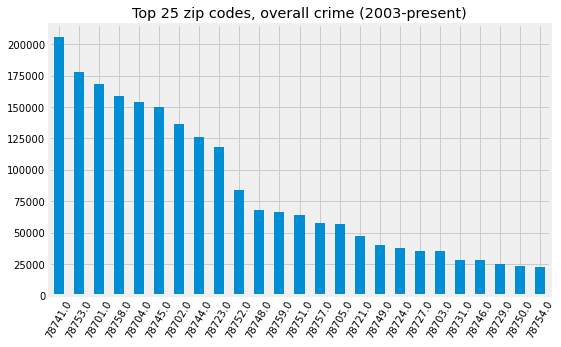

In [6]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 zip codes, overall crime (2003-present)", figsize=(8, 5)
)

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701 (downtown Austin)? 

PUBLIC INTOXICATION               17144
THEFT                             15719
BURGLARY OF VEHICLE                9241
WARRANT ARREST NON TRAFFIC         8967
DWI                                8301
ASSAULT WITH INJURY                7486
VIOL CITY ORDINANCE - OTHER        6188
POSS OF DRUG PARAPHERNALIA         6023
CRIMINAL MISCHIEF                  5784
CRIMINAL TRESPASS                  3896
POSSESSION OF MARIJUANA            3377
DISTURBANCE - OTHER                3340
CUSTODY ARREST TRAFFIC WARR        3001
POSS CONTROLLED SUB/NARCOTIC       2892
CAMPING IN PARK                    2791
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2576
ASSAULT BY CONTACT                 2565
THEFT OF BICYCLE                   2500
URINATING IN PUBLIC PLACE          2336
FAMILY DISTURBANCE                 2133
DOC FIGHTING                       2104
PROTECTIVE ORDER                   2101
ASSAULT W/INJURY-FAM/DATE VIOL     1724
Name: highest_offense_description, dtype

----------------------------------


PUBLIC INTOXICATION               0.102054
THEFT                             0.093571
BURGLARY OF VEHICLE               0.055009
WARRANT ARREST NON TRAFFIC        0.053378
DWI                               0.049414
ASSAULT WITH INJURY               0.044562
VIOL CITY ORDINANCE - OTHER       0.036836
POSS OF DRUG PARAPHERNALIA        0.035853
CRIMINAL MISCHIEF                 0.034431
CRIMINAL TRESPASS                 0.023192
POSSESSION OF MARIJUANA           0.020102
DISTURBANCE - OTHER               0.019882
CUSTODY ARREST TRAFFIC WARR       0.017864
POSS CONTROLLED SUB/NARCOTIC      0.017215
CAMPING IN PARK                   0.016614
VOCO - ALCOHOL  CONSUMPTION       0.016013
CRIMINAL TRESPASS/TRANSIENT       0.015334
ASSAULT BY CONTACT                0.015269
THEFT OF BICYCLE                  0.014882
URINATING IN PUBLIC PLACE         0.013906
FAMILY DISTURBANCE                0.012697
DOC FIGHTING                      0.012525
PROTECTIVE ORDER                  0.012507
ASSAULT W/I

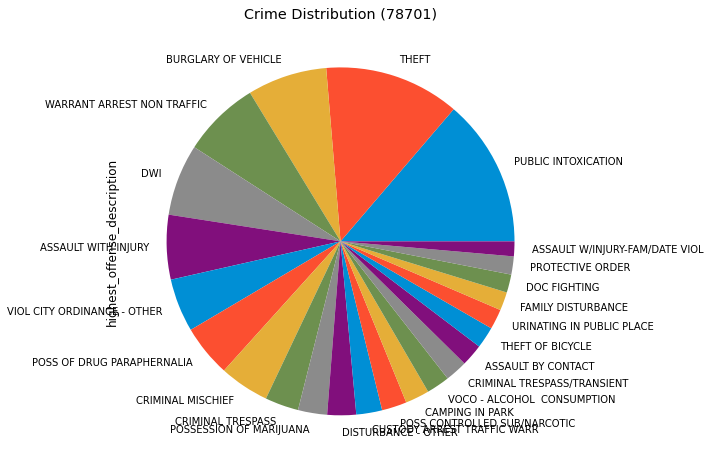

In [7]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
display(df_01_off)
print("----------------------------------")
display(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17077
BURGLARY OF VEHICLE               15918
FAMILY DISTURBANCE                14567
CRIMINAL MISCHIEF                  9411
THEFT BY SHOPLIFTING               7612
ASSAULT W/INJURY-FAM/DATE VIOL     7108
BURGLARY OF RESIDENCE              6048
DWI                                4972
DISTURBANCE - OTHER                4737
CUSTODY ARREST TRAFFIC WARR        4342
HARASSMENT                         4223
AUTO THEFT                         4177
POSS OF DRUG PARAPHERNALIA         3720
PUBLIC INTOXICATION                3363
ASSAULT WITH INJURY                3294
CRIMINAL TRESPASS                  3129
POSS CONTROLLED SUB/NARCOTIC       2965
RUNAWAY CHILD                      2916
WARRANT ARREST NON TRAFFIC         2793
POSSESSION OF MARIJUANA            2697
BURGLARY NON RESIDENCE             2489
VIOL CITY ORDINANCE - OTHER        1866
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.095832
BURGLARY OF VEHICLE               0.089328
FAMILY DISTURBANCE                0.081746
CRIMINAL MISCHIEF                 0.052812
THEFT BY SHOPLIFTING              0.042717
ASSAULT W/INJURY-FAM/DATE VIOL    0.039888
BURGLARY OF RESIDENCE             0.033940
DWI                               0.027902
DISTURBANCE - OTHER               0.026583
CUSTODY ARREST TRAFFIC WARR       0.024366
HARASSMENT                        0.023698
AUTO THEFT                        0.023440
POSS OF DRUG PARAPHERNALIA        0.020876
PUBLIC INTOXICATION               0.018872
ASSAULT WITH INJURY               0.018485
CRIMINAL TRESPASS                 0.017559
POSS CONTROLLED SUB/NARCOTIC      0.016639
RUNAWAY CHILD                     0.016364
WARRANT ARREST NON TRAFFIC        0.015674
POSSESSION OF MARIJUANA           0.015135
BURGLARY NON RESIDENCE            0.013968
VIOL CITY ORDINANCE - OTHER       0.010471
Name: highest_offense_description, dtype: float64

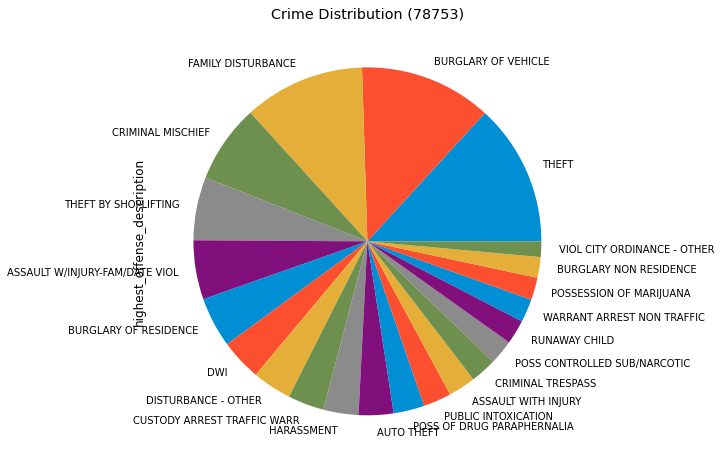

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741 (E Riverside/Oltorf)? 

FAMILY DISTURBANCE                20254
BURGLARY OF VEHICLE               19762
THEFT                             15546
CRIMINAL MISCHIEF                 11004
ASSAULT W/INJURY-FAM/DATE VIOL     9599
BURGLARY OF RESIDENCE              8855
PUBLIC INTOXICATION                6375
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5638
HARASSMENT                         5479
DISTURBANCE - OTHER                5142
AUTO THEFT                         4588
ASSAULT WITH INJURY                4520
CRIMINAL TRESPASS                  3896
POSS CONTROLLED SUB/NARCOTIC       3843
POSSESSION OF MARIJUANA            3791
THEFT BY SHOPLIFTING               3571
POSS OF DRUG PARAPHERNALIA         3531
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2784
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098280
BURGLARY OF VEHICLE               0.095892
THEFT                             0.075435
CRIMINAL MISCHIEF                 0.053395
ASSAULT W/INJURY-FAM/DATE VIOL    0.046578
BURGLARY OF RESIDENCE             0.042968
PUBLIC INTOXICATION               0.030934
CUSTODY ARREST TRAFFIC WARR       0.029168
DWI                               0.027358
HARASSMENT                        0.026586
DISTURBANCE - OTHER               0.024951
AUTO THEFT                        0.022263
ASSAULT WITH INJURY               0.021933
CRIMINAL TRESPASS                 0.018905
POSS CONTROLLED SUB/NARCOTIC      0.018648
POSSESSION OF MARIJUANA           0.018395
THEFT BY SHOPLIFTING              0.017328
POSS OF DRUG PARAPHERNALIA        0.017134
WARRANT ARREST NON TRAFFIC        0.016731
RUNAWAY CHILD                     0.013509
VIOL CITY ORDINANCE - OTHER       0.010656
Name: highest_offense_description, dtype: float64

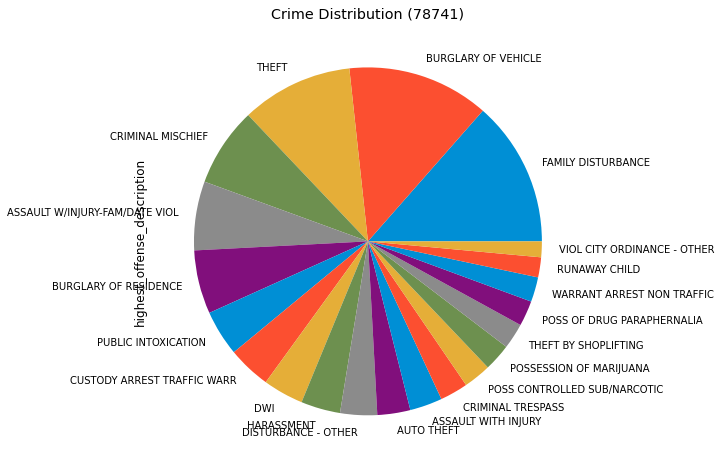

In [9]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages
display(df_41_off)
print("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745 (far south Austin)?

FAMILY DISTURBANCE                14839
BURGLARY OF VEHICLE               14734
THEFT                             13510
CRIMINAL MISCHIEF                  8478
BURGLARY OF RESIDENCE              5862
ASSAULT W/INJURY-FAM/DATE VIOL     5733
HARASSMENT                         5116
DISTURBANCE - OTHER                4495
DWI                                4395
PUBLIC INTOXICATION                3992
CUSTODY ARREST TRAFFIC WARR        3244
BURGLARY NON RESIDENCE             2915
AUTO THEFT                         2831
ASSAULT WITH INJURY                2652
RUNAWAY CHILD                      2591
POSSESSION OF MARIJUANA            2584
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2011
THEFT BY SHOPLIFTING               1963
CRIMINAL TRESPASS                  1943
IDENTITY THEFT                     1561
POSS OF DRUG PARAPHERNALIA         1515
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098771
BURGLARY OF VEHICLE               0.098072
THEFT                             0.089925
CRIMINAL MISCHIEF                 0.056431
BURGLARY OF RESIDENCE             0.039018
ASSAULT W/INJURY-FAM/DATE VIOL    0.038160
HARASSMENT                        0.034053
DISTURBANCE - OTHER               0.029919
DWI                               0.029254
PUBLIC INTOXICATION               0.026571
CUSTODY ARREST TRAFFIC WARR       0.021593
BURGLARY NON RESIDENCE            0.019403
AUTO THEFT                        0.018844
ASSAULT WITH INJURY               0.017652
RUNAWAY CHILD                     0.017246
POSSESSION OF MARIJUANA           0.017199
WARRANT ARREST NON TRAFFIC        0.014031
POSS CONTROLLED SUB/NARCOTIC      0.013386
THEFT BY SHOPLIFTING              0.013066
CRIMINAL TRESPASS                 0.012933
IDENTITY THEFT                    0.010390
POSS OF DRUG PARAPHERNALIA        0.010084
Name: highest_offense_description, dtype: float64

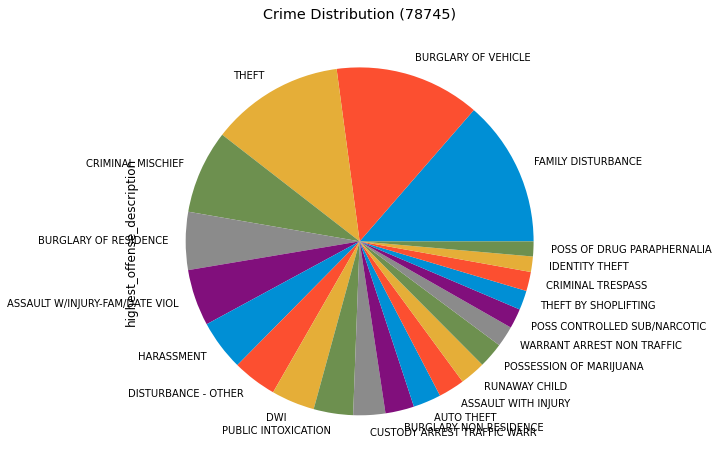

In [10]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_45_off)
print("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705 (UT campus area)?

BURGLARY OF VEHICLE               8600
THEFT                             5592
CRIMINAL MISCHIEF                 4949
THEFT OF BICYCLE                  3458
PUBLIC INTOXICATION               2625
BURGLARY OF RESIDENCE             2116
WARRANT ARREST NON TRAFFIC        1548
CRIMINAL TRESPASS                 1338
AUTO THEFT                        1297
ASSAULT WITH INJURY               1243
DWI                               1218
HARASSMENT                        1207
FAMILY DISTURBANCE                1179
DISTURBANCE - OTHER               1112
BURGLARY NON RESIDENCE             872
CRIMINAL TRESPASS/TRANSIENT        868
VIOL CITY ORDINANCE - OTHER        791
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           775
ASSAULT W/INJURY-FAM/DATE VIOL     689
POSSESSION OF MARIJUANA            658
ASSAULT BY CONTACT                 612
Name: highest_offense_description, dtype: int64

----------------------------------


BURGLARY OF VEHICLE               0.151158
THEFT                             0.098288
CRIMINAL MISCHIEF                 0.086986
THEFT OF BICYCLE                  0.060780
PUBLIC INTOXICATION               0.046138
BURGLARY OF RESIDENCE             0.037192
WARRANT ARREST NON TRAFFIC        0.027208
CRIMINAL TRESPASS                 0.023517
AUTO THEFT                        0.022797
ASSAULT WITH INJURY               0.021848
DWI                               0.021408
HARASSMENT                        0.021215
FAMILY DISTURBANCE                0.020723
DISTURBANCE - OTHER               0.019545
BURGLARY NON RESIDENCE            0.015327
CRIMINAL TRESPASS/TRANSIENT       0.015256
VIOL CITY ORDINANCE - OTHER       0.013903
CUSTODY ARREST TRAFFIC WARR       0.013762
GRAFFITI                          0.013622
ASSAULT W/INJURY-FAM/DATE VIOL    0.012110
POSSESSION OF MARIJUANA           0.011565
ASSAULT BY CONTACT                0.010757
Name: highest_offense_description, dtype: float64

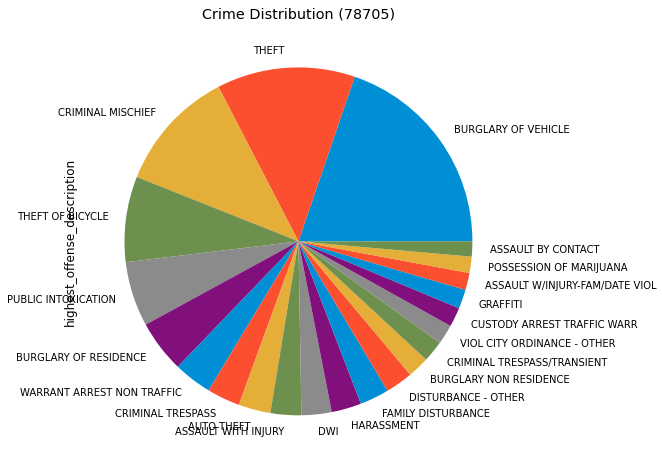

In [11]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]

# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_05_off)
print("----------------------------------")
display(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed? 

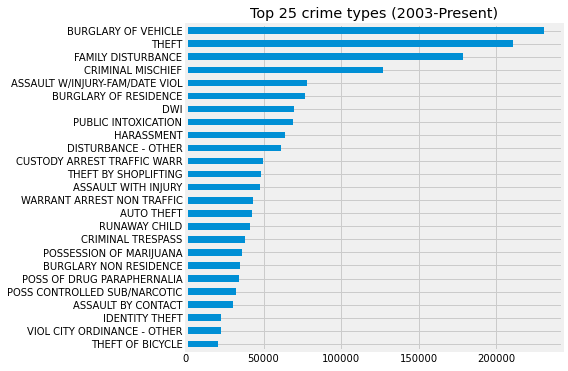

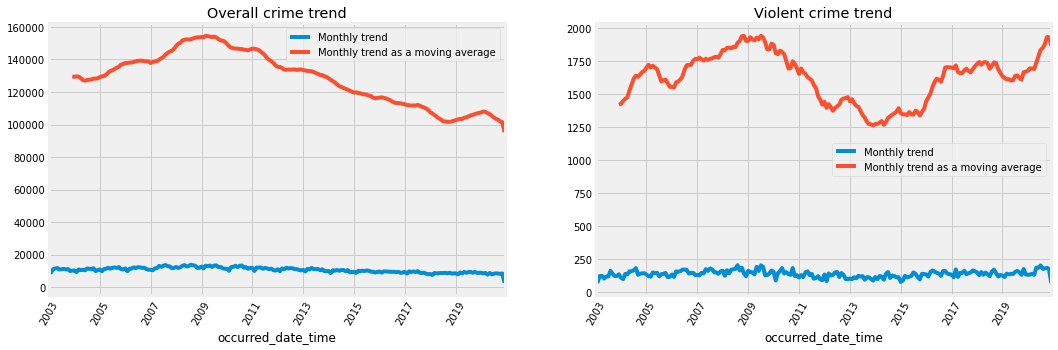

In [12]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]

# Top 25 crime types
df.highest_offense_description.value_counts().head(25).sort_values().plot.barh(
    figsize=(6, 6), title="Top 25 crime types (2003-Present)"
)
plt.show()

# Visualizing trends (overall and violent)
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
df.resample("M").size().plot(ax=axs[0])
df.resample("M").size().rolling(12).sum().plot(title="Overall crime trend", rot=60, ax=axs[0])
axs[0].legend(["Monthly trend", "Monthly trend as a moving average"])
df_viol.resample("M").size().plot(ax=axs[1])
df_viol.resample("M").size().rolling(12).sum().plot(
    title="Violent crime trend", rot=60, ax=axs[1]
)
axs[1].legend(["Monthly trend", "Monthly trend as a moving average"])
plt.show()

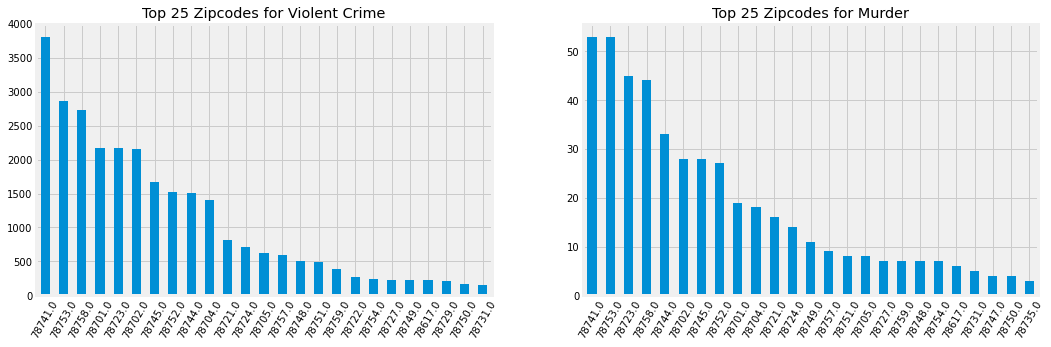

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,,
78610.0,1,0,0,0,0
78613.0,14,11,0,1,6
78617.0,120,62,0,6,36
78621.0,1,0,0,0,0
78634.0,1,0,0,0,0
78652.0,2,0,0,0,0
78653.0,10,3,0,1,1
78660.0,66,27,0,2,17
78664.0,3,0,0,0,0


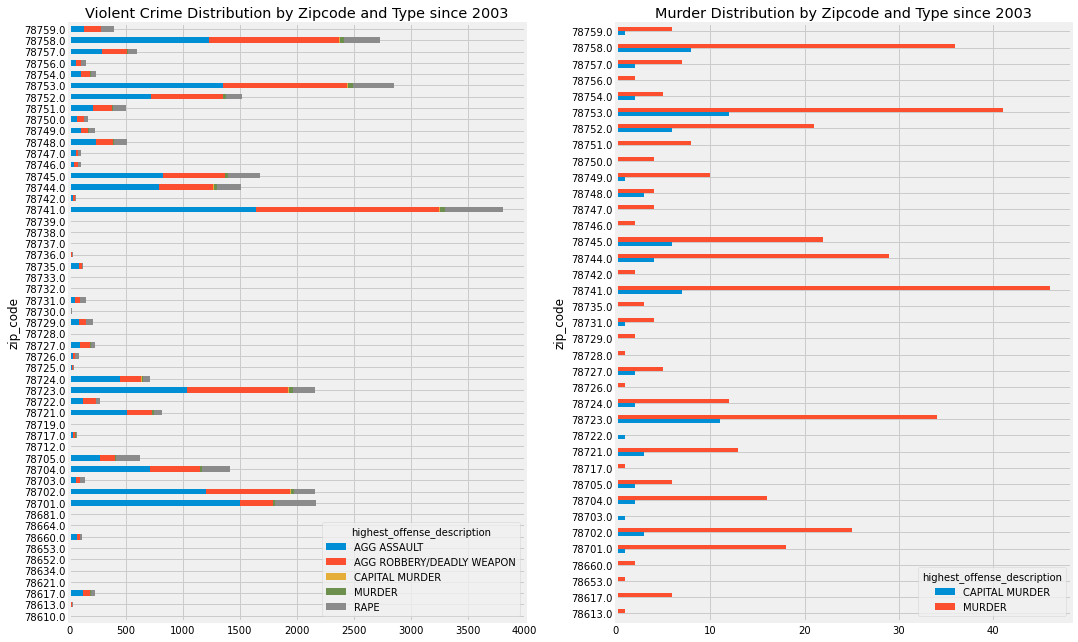

In [13]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=2)
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Violent Crime", rot=60, ax=axs[0]
)
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Murder", rot=60, ax=axs[1]
)
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
display(viol_freq)

fig, axs = plt.subplots(figsize=(16, 11), ncols=2)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_freq.plot.barh(
    title="Murder Distribution by Zipcode and Type since 2003", ax=axs[1]
)
plt.show()

Overall crime, 2017-present


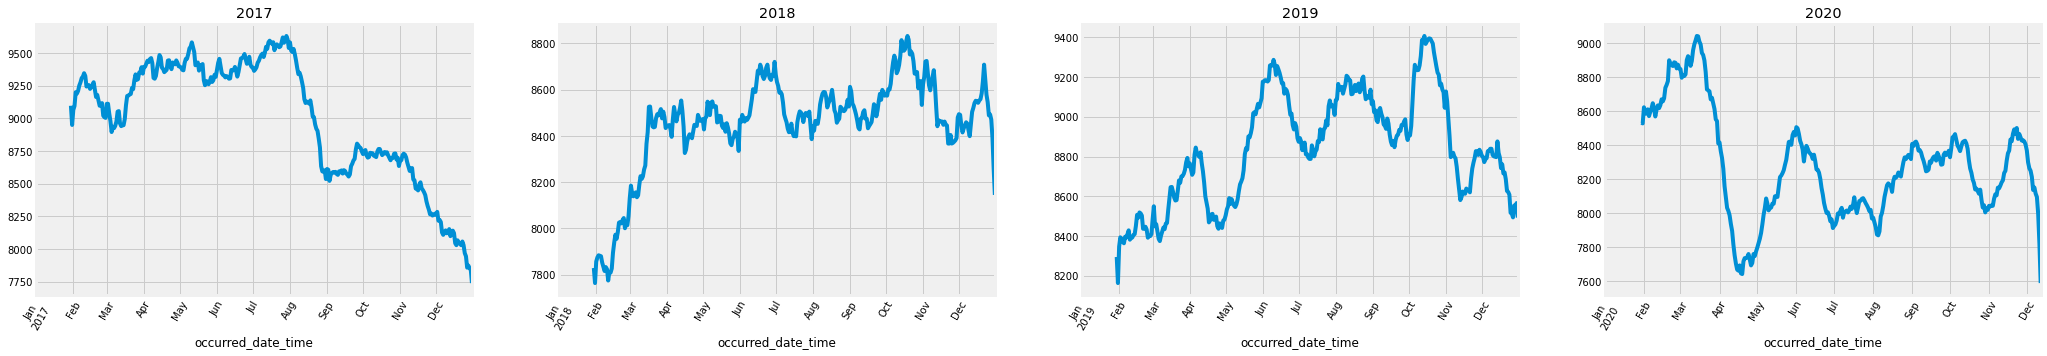

Violent crime, 2017-present


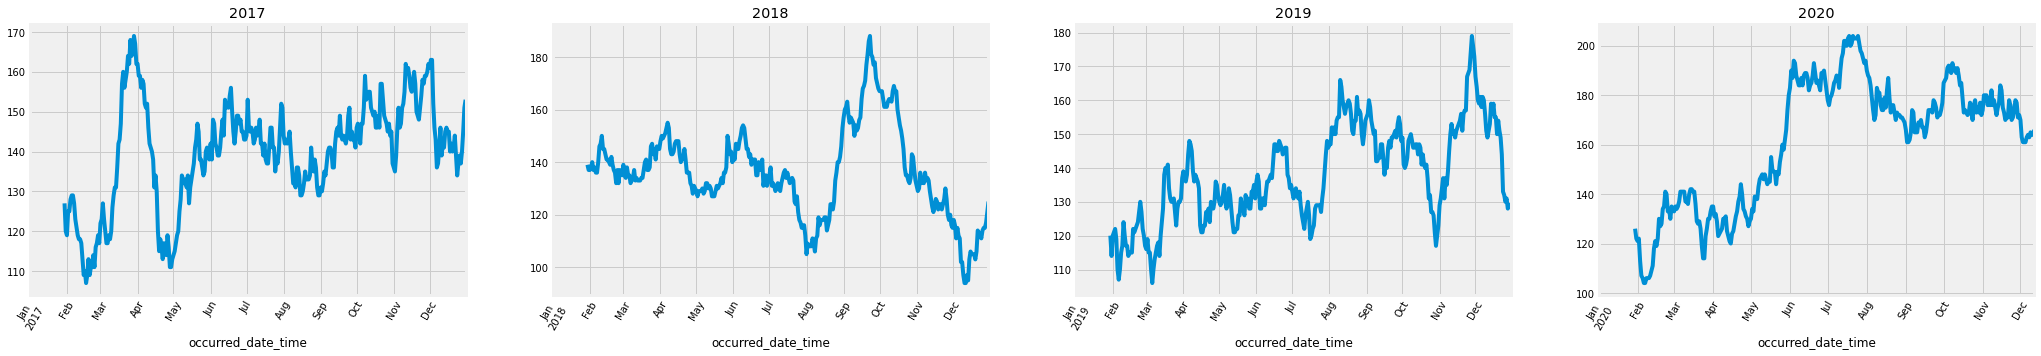

In [14]:
print("===========================")
print("Overall crime, 2017-present")
print("===========================")
fig, axs = plt.subplots(ncols=4, figsize=(32, 5))
df_17.resample("D").size().rolling(30).sum().plot(rot=60, title="2017", ax=axs[0])
df_18.resample("D").size().rolling(30).sum().plot(rot=60, title="2018", ax=axs[1])
df_19.resample("D").size().rolling(30).sum().plot(rot=60, title="2019", ax=axs[2])
df_20.resample("D").size().rolling(30).sum().plot(rot=60, title="2020", ax=axs[3])
plt.show()


print("===========================")
print("Violent crime, 2017-present")
print("===========================")
fig, axs = plt.subplots(ncols=4, figsize=(32, 5))
df_viol_17.resample("D").size().rolling(30).sum().plot(rot=60, title="2017", ax=axs[0])
df_viol_18.resample("D").size().rolling(30).sum().plot(rot=60, title="2018", ax=axs[1])
df_viol_19.resample("D").size().rolling(30).sum().plot(rot=60, title="2019", ax=axs[2])
df_viol_20.resample("D").size().rolling(30).sum().plot(rot=60, title="2020", ax=axs[3])
plt.show()

#### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

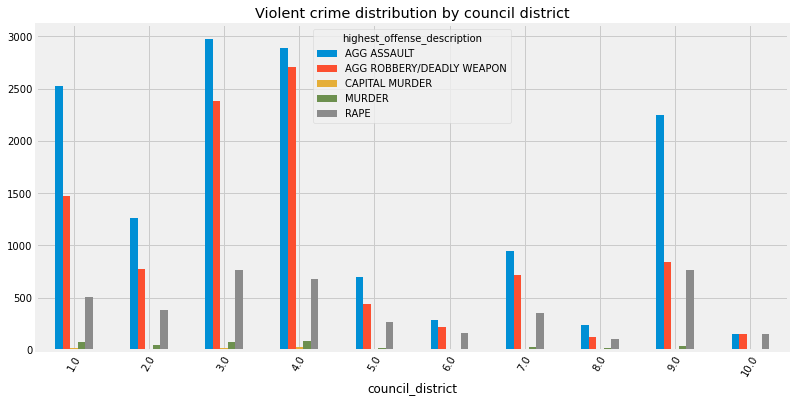

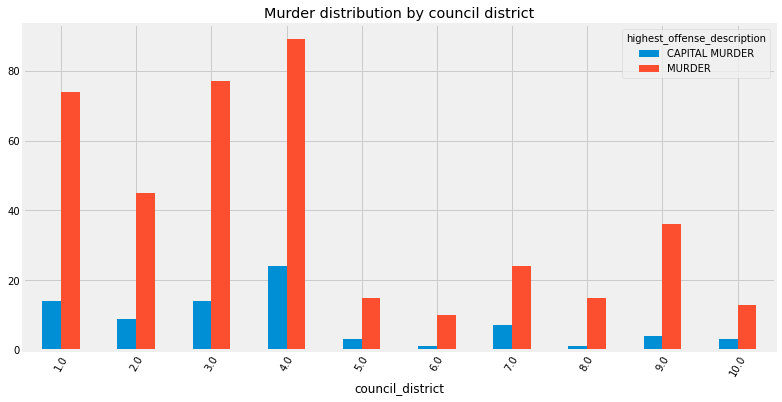

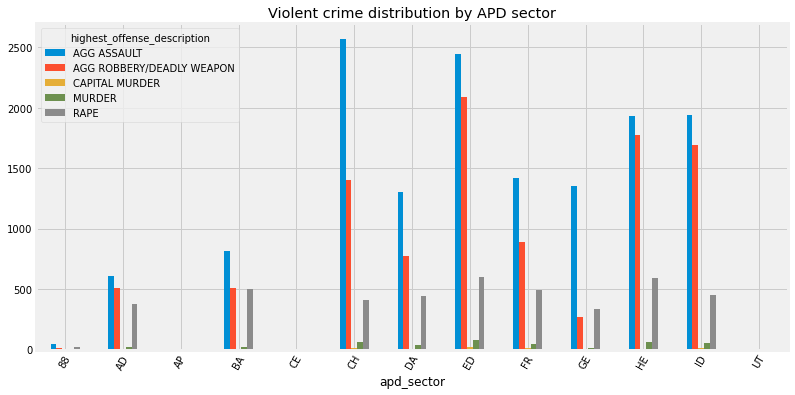

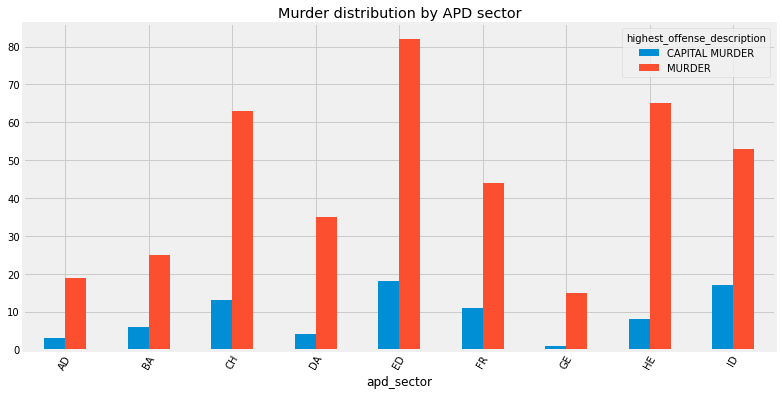

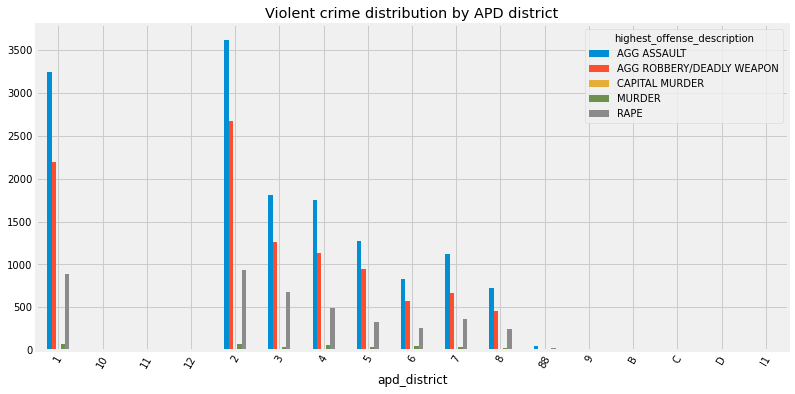

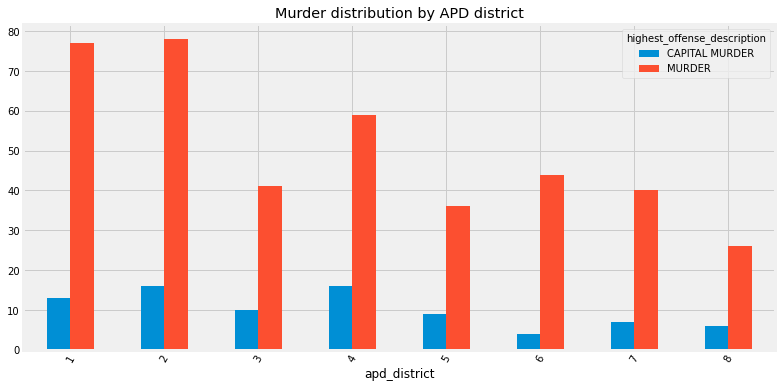

In [15]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by council district"
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(figsize=(12, 6), rot=60, title="Murder distribution by council district")
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD district"
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD district"
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
location_type,,,,,
ABANDONED/CONDEMNED STRUCTURE,13,7,0,1,4
AMUSEMENT PARK,0,1,0,1,0
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,2,0,0,0,0
ATM SEPARATE FROM BANK,1,2,0,0,0
AUTO DEALERSHIP NEW / USED,10,2,0,0,1
BANKS / SAVINGS & LOAN,5,134,0,1,1
BAR / NIGHT CLUB,652,45,2,7,77
CAMP / CAMPGROUND,20,2,0,0,2
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE,20,5,1,0,7


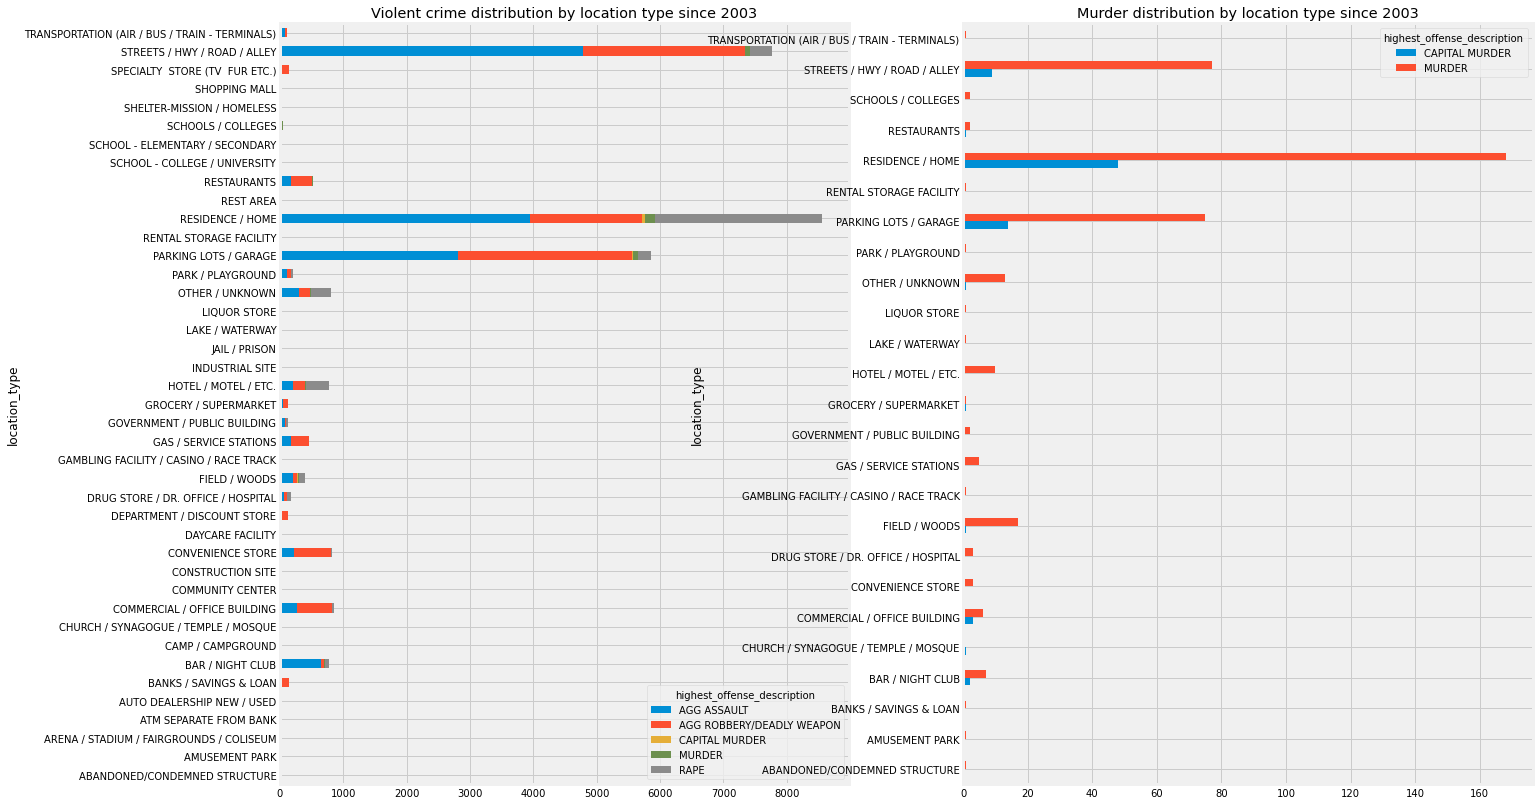

In [16]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
display(viol_loc)

mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

fig, axs = plt.subplots(figsize=(20, 14), ncols=2)
viol_loc.plot.barh(
    title="Violent crime distribution by location type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_loc.plot.barh(title="Murder distribution by location type since 2003", ax=axs[1])
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [17]:
# Aggravated assault as a heatmap
agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [18]:
agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [19]:
# As a heatmap
mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [20]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                82
9515 N LAMAR BLVD           66
1700 BURTON DR              62
00 BLOCK UNKNOWN            59
6409 SPRINGDALE RD          59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
9200 NORTH PLZ              53
1071 CLAYTON LN             53
1030 NORWOOD PARK BLVD      53
2237 E RIVERSIDE DR         51
1137 GUNTER ST              51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [21]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(31)

6407 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
6409 SPRINGDALE RD           3
4700 E RIVERSIDE DR          3
8800 N IH 35 SVRD SB         3
8225 SAM RAYBURN DR          2
10503 N LAMAR BLVD           2
9601 MIDDLE FISKVILLE RD     2
8912 N LAMAR BLVD            2
605 MASTERSON PASS           2
744 W WILLIAM CANNON DR      2
1137 GUNTER ST               2
6600 ED BLUESTEIN BLVD SB    2
601 E 15TH ST                2
2508 E RIVERSIDE DR          2
201 W 5TH ST                 2
6118 FAIRWAY ST              2
7000 DECKER LN               2
1711 RUTLAND DR              2
9200 NORTH PLZ               2
9010 GALEWOOD DR             2
2400 WICKERSHAM LN           2
815 W SLAUGHTER LN           2
2915 S IH 35 SVRD NB         2
10610 MORADO CIR             2
2101 ELMONT DR               2
9220 N IH 35 SVRD SB         2
2713 S CONGRESS AVE          2
833 FAIRFIELD DR             2
1050 SPRINGDALE RD           2
2501 ANKEN DR                2
Name: address, dtype: int64

## IV. Summary 

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.23 percentage points higher than the number 2 area 78753 which hosts 7.82% of overall crime.

As we can see, violent crime spiked tremendously after 2018, and especially for 2020 so far.

Years 2010 and 2016 had the most number of murders. However, and alarmingly, as of 11/23/2020, we've now had more murders this year than any other since 2003. Presently, the murder count for 2020 is at 39!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

In [22]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")